# Data exploration 

In [43]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import esda
#----Visulisation----
import contextily
import seaborn
import matplotlib.pyplot as plt
from splot import esda as esdaplot
%matplotlib inline

Load the data set and clean it 

In [2]:
df_chicago=pd.read_csv('Crime/Crimes_-_2001_to_Present.csv',index_col='ID')
# clean the data without geocode and time stamp
df_chicago=df_chicago.dropna(subset=['Date','Location'])
df_chicago['Date']=pd.to_datetime(df_chicago['Date'])
# correct the value of crime type
df_chicago['Primary Type'].replace('CRIM SEXUAL ASSAULT','CRIMINAL SEXUAL ASSAULT',inplace=True)

In [3]:
#get geometry point of data
df_chicago['Location'] = df_chicago.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
# get geopandas frame
df_chicago=gpd.GeoDataFrame(df_chicago,geometry='Location')

Now combine the data set with the [boundary data of chicago](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

In [4]:
geof='Crime/Boundaries - Community Areas (current).geojson'
chicago_area=gpd.read_file(geof)
# only keep teh information of commuity and geometry
chicago_area=chicago_area[['community','area_numbe','geometry']]
chicago_area=chicago_area.rename(columns={'area_numbe':'area_num'})

In [5]:
#set crs to the geo dataframe
df_chicago=df_chicago.set_crs(chicago_area.crs)
#spatial join so that crime points are within different communities
df_chicago= df_chicago.sjoin(chicago_area, how='inner',predicate='within')

In [7]:
df_chicago.head()

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,index_right,community,area_num
ID,,,,,,,,,,,,,,,,,,,,,
10224853,HY411790,2015-09-05 16:15:00,041XX W FIFTH AVE,1570,SEX OFFENSE,PUBLIC INDECENCY,SIDEWALK,True,False,1132,...,1148735.0,1896483.0,2015,09/17/2015 11:37:18 AM,41.871884,-87.729404,POINT (-87.72940 41.87188),26,WEST GARFIELD PARK,26
10232192,HY419551,2015-09-10 16:00:00,039XX W GLADYS AVE,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,RESIDENCE,False,True,1132,...,1150207.0,1898066.0,2015,02/10/2018 03:50:01 PM,41.876199,-87.723958,POINT (-87.72396 41.87620),26,WEST GARFIELD PARK,26
10329071,HY519515,2015-11-29 15:00:00,038XX W WILCOX ST,281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,OTHER,False,False,1122,...,1150799.0,1899061.0,2015,02/10/2018 03:50:01 PM,41.878918,-87.721758,POINT (-87.72176 41.87892),26,WEST GARFIELD PARK,26
10240564,HY428120,2015-09-17 20:00:00,039XX W WASHINGTON BLVD,281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1122,...,1150014.0,1900125.0,2015,02/10/2018 03:50:01 PM,41.881853,-87.724613,POINT (-87.72461 41.88185),26,WEST GARFIELD PARK,26
10242207,HY430128,2015-09-18 22:35:00,044XX W MADISON ST,1506,PROSTITUTION,SOLICIT ON PUBLIC WAY,SIDEWALK,True,False,1113,...,1146742.0,1899645.0,2015,02/10/2018 03:50:01 PM,41.880599,-87.736640,POINT (-87.73664 41.88060),26,WEST GARFIELD PARK,26


In [9]:
# check the type and count of crime data
df_chicago.groupby('Primary Type').size().sort_values()


Primary Type
DOMESTIC VIOLENCE                 1
HUMAN TRAFFICKING                67
STALKING                       3798
SEX OFFENSE                   26328
CRIMINAL SEXUAL ASSAULT       28748
OFFENSE INVOLVING CHILDREN    47860
PROSTITUTION                  68595
dtype: int64

In [6]:
# subset data of interest
# 1. get crime against children 
crime_children= df_chicago[df_chicago['Primary Type']=='OFFENSE INVOLVING CHILDREN']
# 2.combine the sexual violence in one category as sex crime to  analysis
target_type=['SEX OFFENSE ','CRIMINAL SEXUAL ASSAULT']
crime_sexual= df_chicago[df_chicago['Primary Type'].isin(target_type)]
print(f'Size of violence against children: {crime_children.shape[0]}')
print(f'Size of violence against women:{crime_sexual.shape[0]}')

Size of violence against children: 47860
Size of violence against women:28748


# Spatial Pattern Analysis
Code in this section is adapted from 
[construct spatial weight matrix](https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal.weights.W)

In [7]:
# Visualise the distribution of different type of violence
# First get the count of crime in different communities
# In this part, the geometry is polygon of communities
count_child=chicago_area.merge(crime_children.groupby('community').size().reset_index(name='crime_count'),on='community')
#child_count.info()
count_sexual=chicago_area.merge(crime_sexual.groupby('community').size().reset_index(name='crime_count'),on='community')


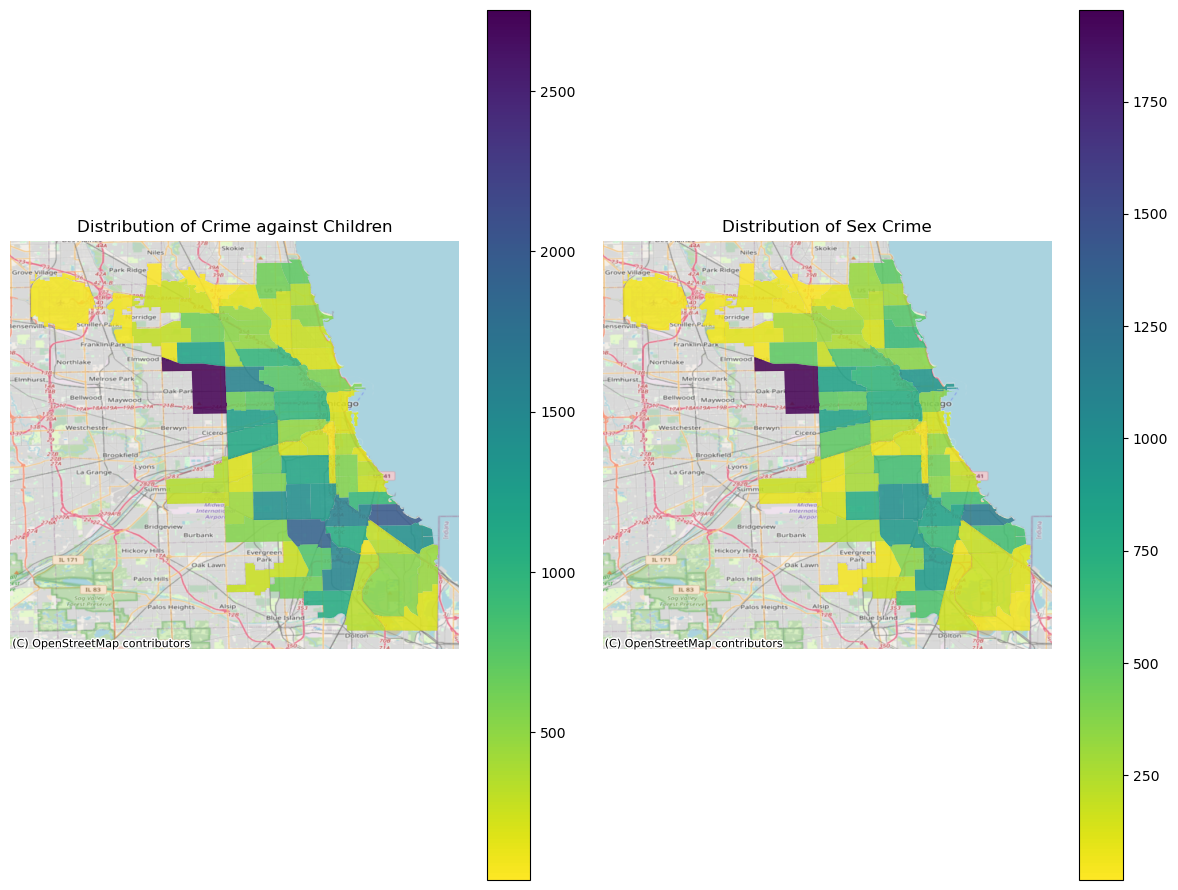

In [8]:
# visualise the distribution of crime count
#set up figure and a single axis
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(12, 9))
# Build choropleth
#ax1=axs[0]
count_child.plot(
    column='crime_count',
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.85,
    legend=True,
    cmap="viridis_r",
    ax=axs[0],
       
)
# add basemap
contextily.add_basemap(
    axs[0],
    crs=count_child.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)

# Build choropleth of sex crime
count_sexual.plot(
    column='crime_count',
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.85,
    legend=True,
    cmap="viridis_r",
    ax=axs[1],
       
)
# add basemap
contextily.add_basemap(
    axs[1],
    crs=count_sexual.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
# add title
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(["Distribution of Crime against Children",
                  "Distribution of Sex Crime"][i])
fig.tight_layout()

## Spatial Autocorrelation analysis
### Glocal Autocorrelation

In [9]:
#generate spaital weight matrix
# apply the Queen's rule to construct
import libpysal as ps 
from libpysal.weights import Queen
w_c=Queen.from_dataframe(count_child)
# row-standardisation
w_c.transform='R'
# get the spatial lag of crime count
count_child['crime_count_lag']= ps.weights.spatial_lag.lag_spatial(w_c,count_child['crime_count'])
# get the standardised crime count and its spatial lag
count_child['crime_count_std']=count_child['crime_count']-count_child['crime_count'].mean()
count_child['crime_count_lag_std']=count_child['crime_count_lag']-count_child['crime_count_lag'].mean()
# use the row standardised weight to calculate Moran's I
moran= esda.moran.Moran(count_child['crime_count'],w_c)
# retrive the value of Moran's I
print(f"The moran's I for crime against children:{round(moran.I,5)}")
# how likely it is to obtain a pattern like distribution of crime counts in a total randomness situation
# calculated empirical p-value
print(f'empirical p-value:{moran.p_sim}')

The moran's I for crime against children:0.30646
empirical p-value:0.001


In [10]:
# apply the Queen's rule to construct
import libpysal as ps 
from libpysal.weights import Queen
w_s=Queen.from_dataframe(count_sexual)
# row-standardisation
w_s.transform='R'
# get the spatial lag of crime count
count_sexual['crime_count_lag']= ps.weights.spatial_lag.lag_spatial(w_s,count_sexual['crime_count'])
# get the standardised crime count and its spatial lag
count_sexual['crime_count_std']=count_sexual['crime_count']-count_sexual['crime_count'].mean()
count_sexual['crime_count_lag_std']=count_sexual['crime_count_lag']-count_sexual['crime_count_lag'].mean()
# use the row standardised weight to calculate Moran's I
moran= esda.moran.Moran(count_sexual['crime_count'],w_s)
# retrive the value of Moran's I
print(f"The moran's I for crime against women:{round(moran.I,5)}")
# how likely it is to obtain a pattern like distribution of crime counts in a total randomness situation
# calculated empirical p-value
print(f'empirical p-value:{moran.p_sim}')

The moran's I for crime against women:0.29698
empirical p-value:0.001


### Local Spatial Autocorrelation 


Since the global index does not indicate the type of clustering, local indicator of spatial associations shall be caluclated to examine the geographical clusters of crime.

In [11]:
from esda.moran import Moran_Local
lisa_children= esda.moran.Moran_Local(count_child['crime_count'],w_c)
lisa_sex= esda.moran.Moran_Local(count_sexual['crime_count'],w_s)


In [34]:
# Visulise LISA to find the statistical clusters
# 1. Choropleth of local statistics of each community
# 2. The quadrant each community is assigned into
# 3. The significance of statistics

## In this case let's take the count of crime agaisnt children for example


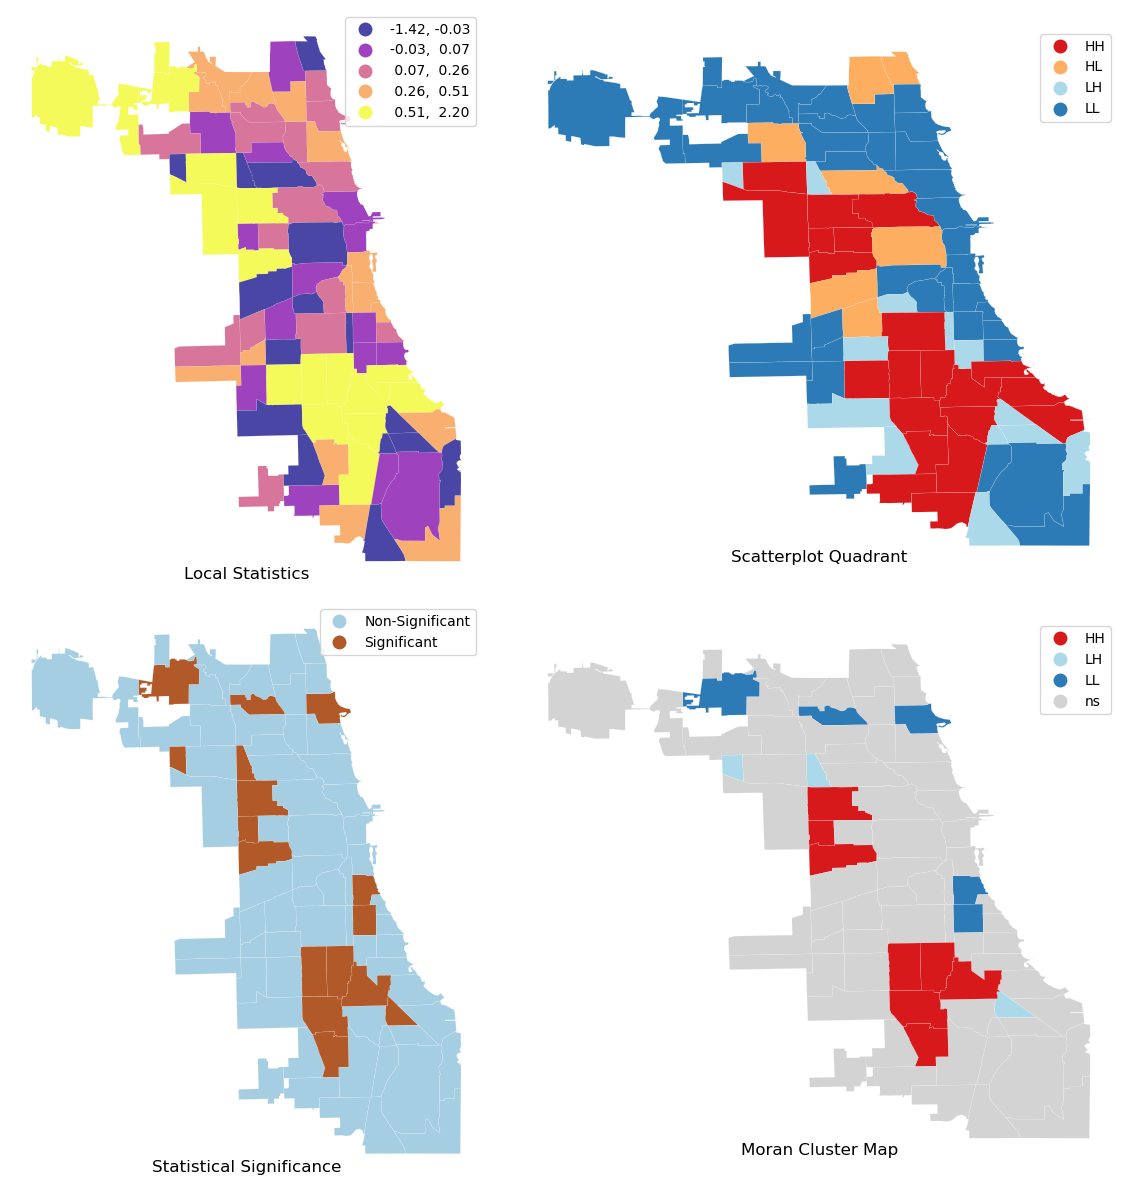

In [12]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
count_child.assign(
    Is=lisa_children.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa_children, count_child, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa_children.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=count_child.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
count_child.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_children, count_child, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
#plt.title("LISA of Crime Against Children")
plt.show()

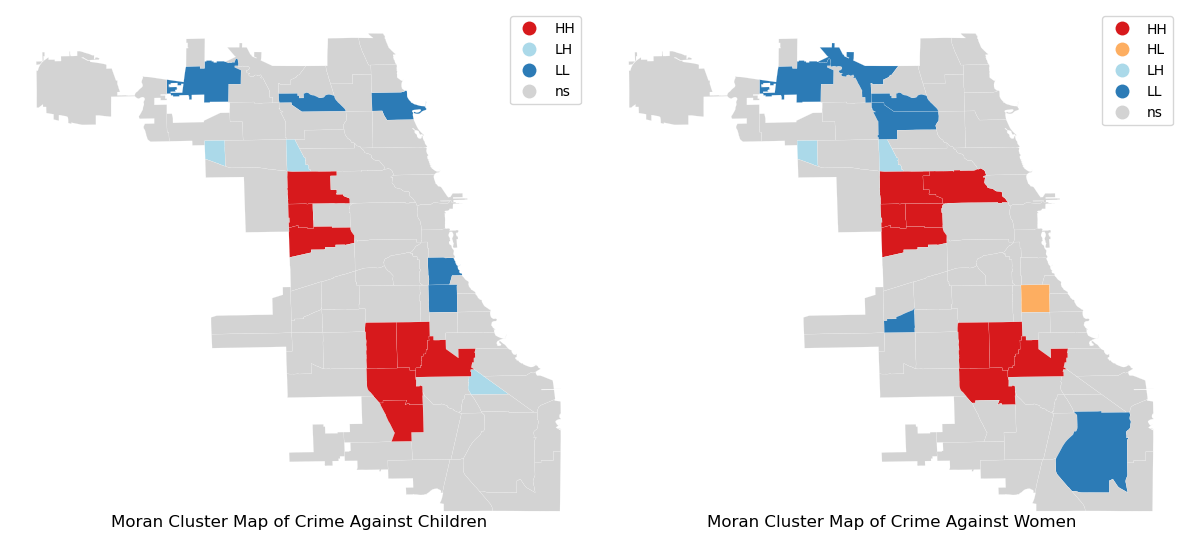

In [13]:
# combine Quadrant categories with significance level to create  cluster map
from splot import esda as esdaplot
# Set up figure and axes
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Grab second axis of local statistics
ax = axs[0]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_children, count_child, p=0.05, ax=ax)
ax=axs[1]
esdaplot.lisa_cluster(lisa_sex, count_sexual, p=0.05, ax=ax)
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Moran Cluster Map of Crime Against Children",
            "Moran Cluster Map of Crime Against Women",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()


## KDE analysis


C:\Users\skyla\AppData\Local\Temp\ipykernel_24988\1952343394.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(data=crime_children,


Text(0.5, 1.0, 'KDE of Crime Against Children')

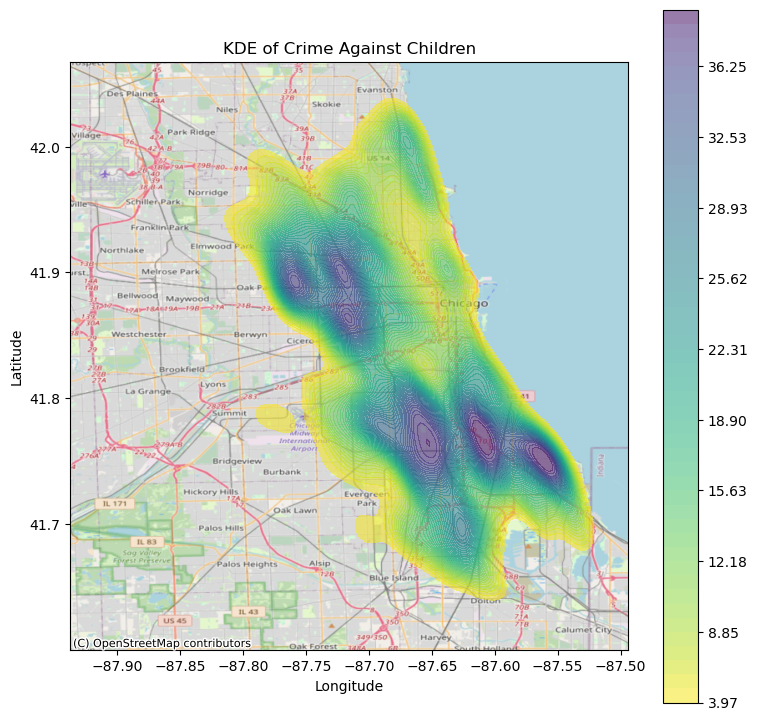

In [19]:
# Set up figure and axis
f, ax = plt.subplots(figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(data=crime_children,
    x=crime_children["Longitude"],
    y=crime_children["Latitude"],
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
    legend=True,
    cbar=True,ax=ax
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=crime_children.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
ax.set_title('KDE of Crime Against Children')


C:\Users\skyla\AppData\Local\Temp\ipykernel_24988\148241675.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(data=crime_sexual,


Text(0.5, 1.0, 'KDE of Sex Crime')

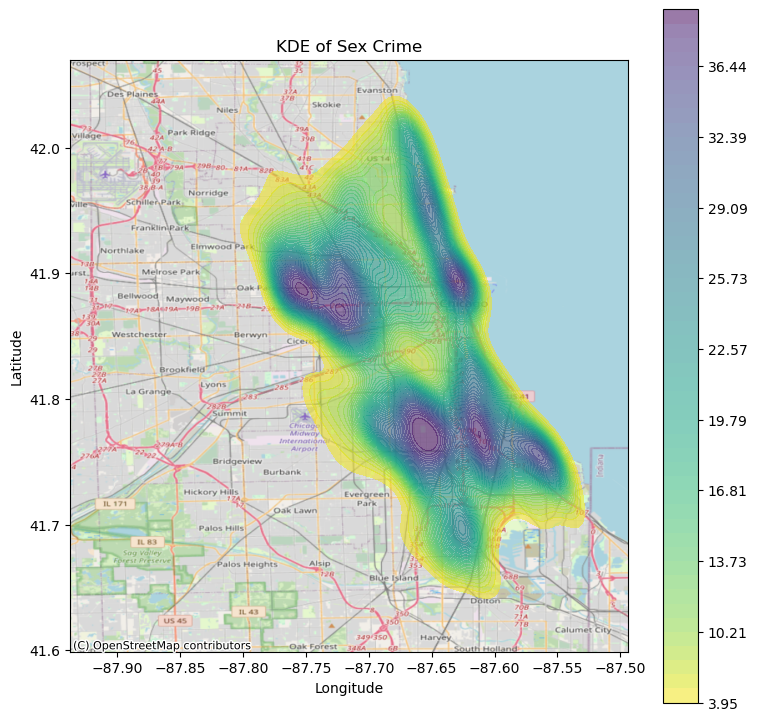

In [20]:

f, ax = plt.subplots(figsize=(9, 9))
## Plot KDE of sex crime
seaborn.kdeplot(data=crime_sexual,
    x=crime_sexual["Longitude"],
    y=crime_sexual["Latitude"],
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
    legend=True,
    cbar=True,ax=ax
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=crime_sexual.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
ax.set_title("KDE of Sex Crime")

# Temporal analysis


In [91]:
#check the length of temporal series

#print(f'The earliest time:{crime_children.Date.min()}')
#print(f'The latest time:{crime_children.Date.min()}')
# get data within 20 years
start_date='2001-01-01 00:00:00'
end_date='2020-12-31 23:59:00'
crime_children = crime_children.loc[(crime_children.Date >= start_date) & (crime_children.Date <= end_date)]
crime_sexual = crime_sexual.loc[(crime_sexual.Date >= start_date) & (crime_sexual.Date <= end_date)]


In [92]:
# get the temporal series of crime data
temp_children=crime_children.groupby(pd.Grouper(key='Date',freq='M')).size()
temp_sex=crime_sexual.groupby(pd.Grouper(key='Date',freq='M')).size()


Text(0.5, 1.0, 'Number of sex crime cases per month')

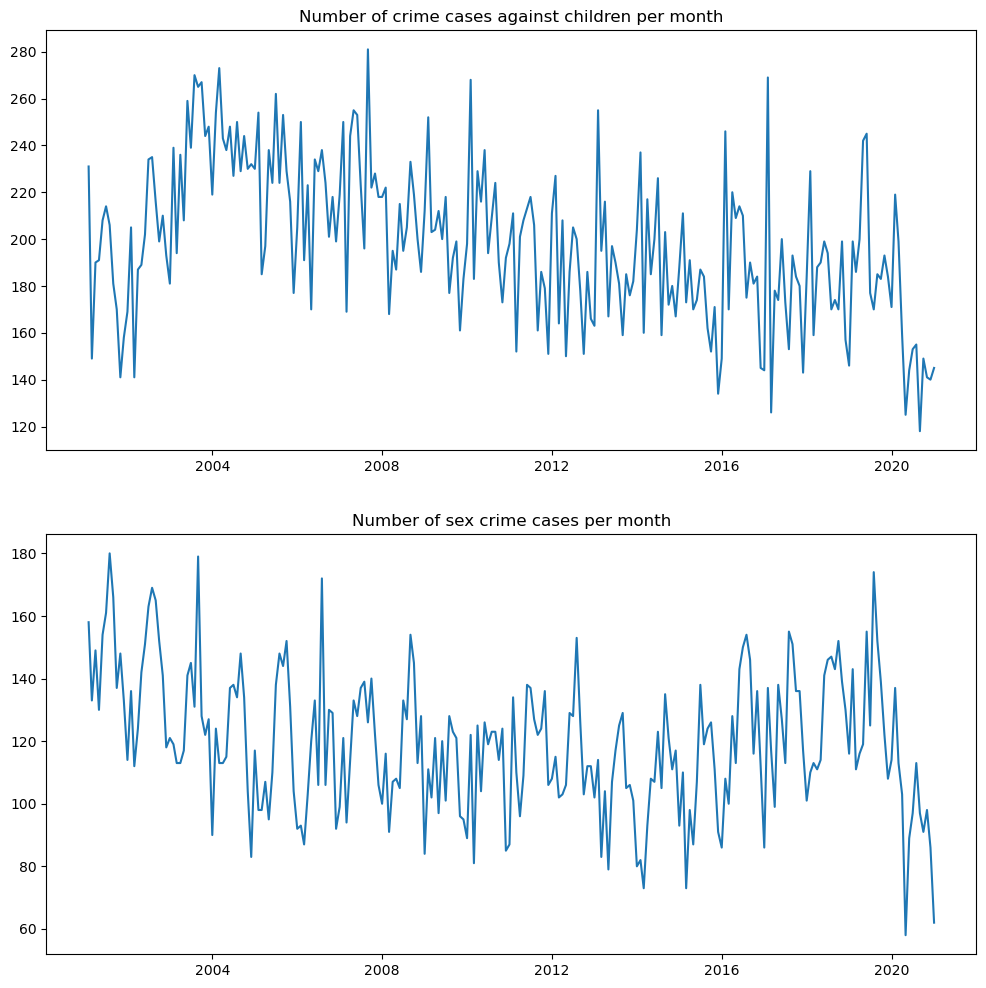

In [94]:
# visualise it
fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
ax=axs[0]
ax.plot(temp_children.index,temp_children.values)
ax.set_title('Number of crime cases against children per month')


ax=axs[1]
ax.plot(temp_sex.index,temp_sex.values)
ax.set_title('Number of sex crime cases per month')


Check whether the temporal series is sationary

In [95]:
# conduct Augmented Dickey-Fuller Test
# If the ADF statistics has low p-value and close confidence interval, the time-series will be considered as stationary
from statsmodels.tsa.stattools import adfuller
res=adfuller(temp_children.values)
print(f'Temporal series of crime involves children')
print(f'ADF Statistics:{res[0]}')
print(f'p-value:{res[1]}')
print(f'Critical values')
for k,v in res[4].items():
    print(f'\t{k}: {v}')

Temporal series of crime involves children
ADF Statistics:-1.1104051087665838
p-value:0.7109046806422059
Critical values
	1%: -3.4594900381360034
	5%: -2.8743581895178485
	10%: -2.573601605503697


In [96]:
res=adfuller(temp_sex.values)
print(f'Temporal series of sex crime')
print(f'ADF Statistics:{res[0]}')
print(f'p-value:{res[1]}')
print(f'Critical values')
for k,v in res[4].items():
    print(f'\t{k}: {v}')

Temporal series of sex crime
ADF Statistics:-1.7325555665701033
p-value:0.4144217110861933
Critical values
	1%: -3.4597521044060353
	5%: -2.874472927517147
	10%: -2.5736628197530864


Both temporal series is not stationary, check acf and pacf.

c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


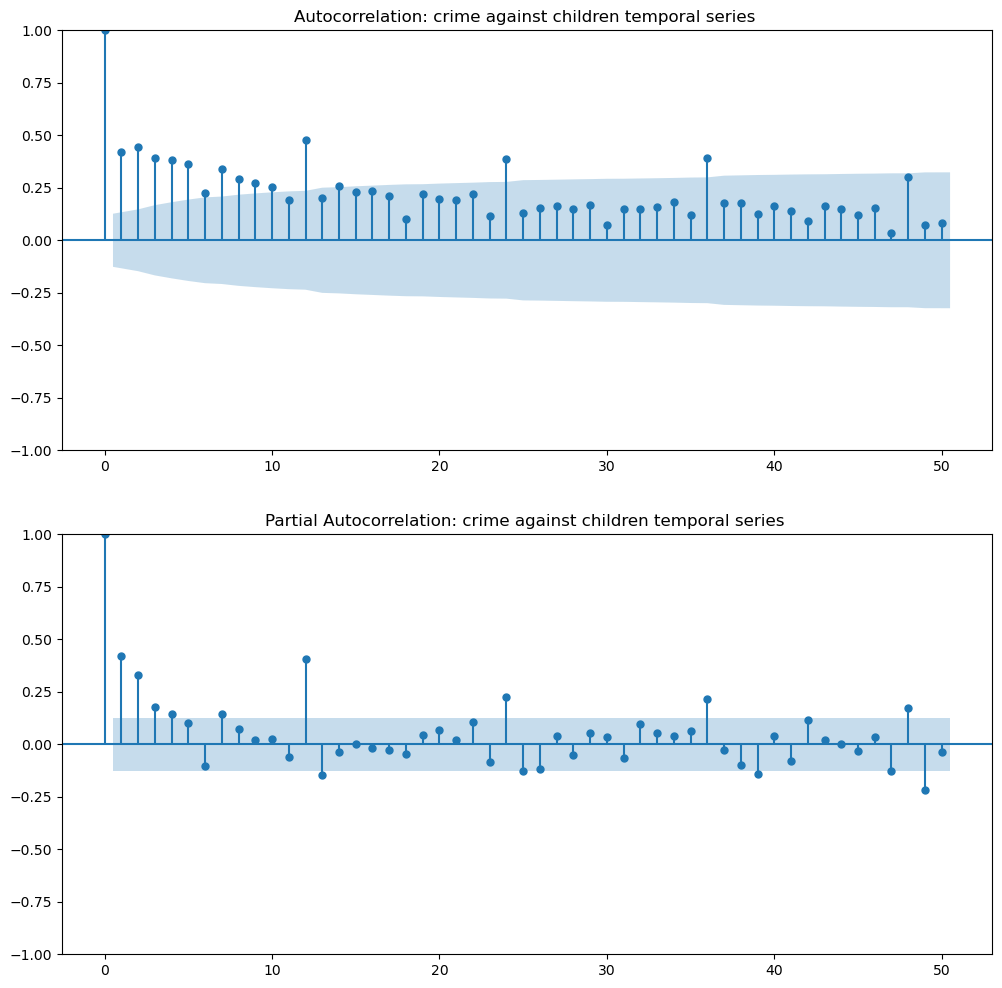

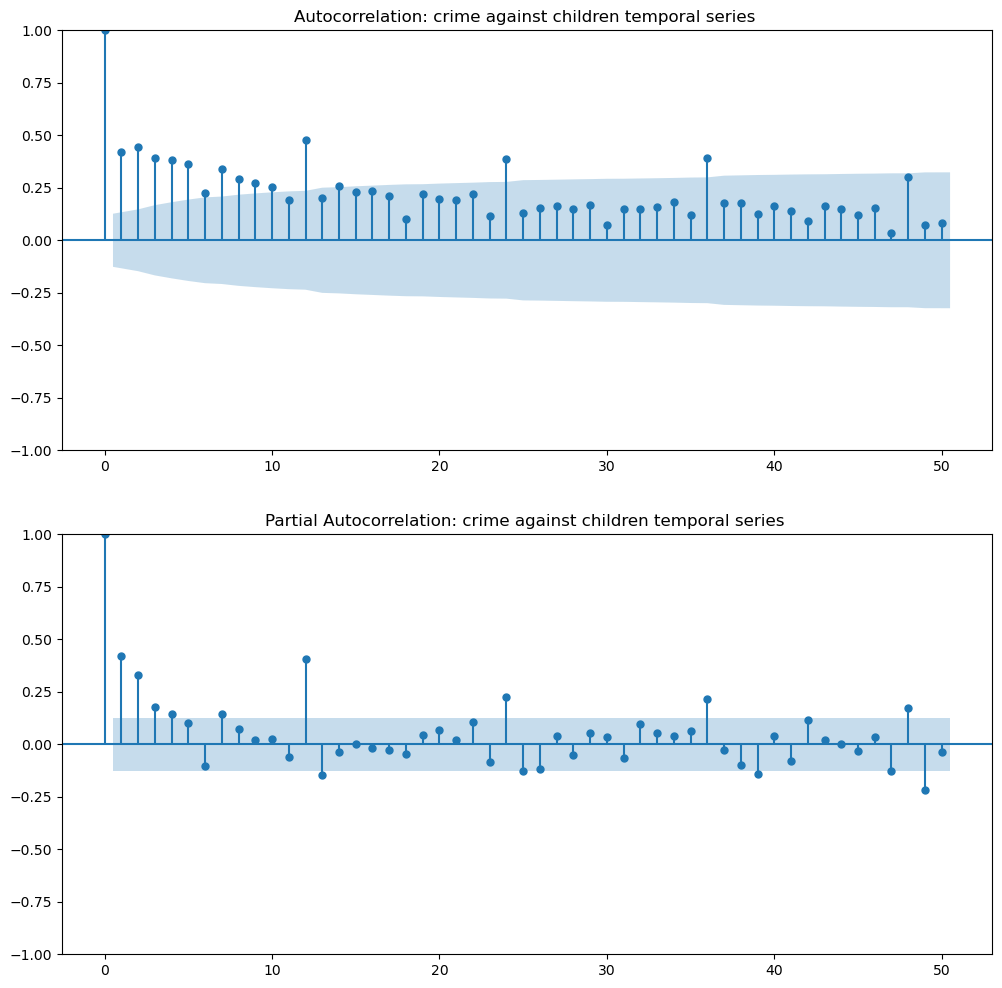

In [97]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(12,12))

plot_acf(temp_children.values,title='Autocorrelation: crime against children temporal series ',lags=50,ax=axs[0])
plot_pacf(temp_children.values,title='Partial Autocorrelation: crime against children temporal series ',lags=50,ax=axs[1])

c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


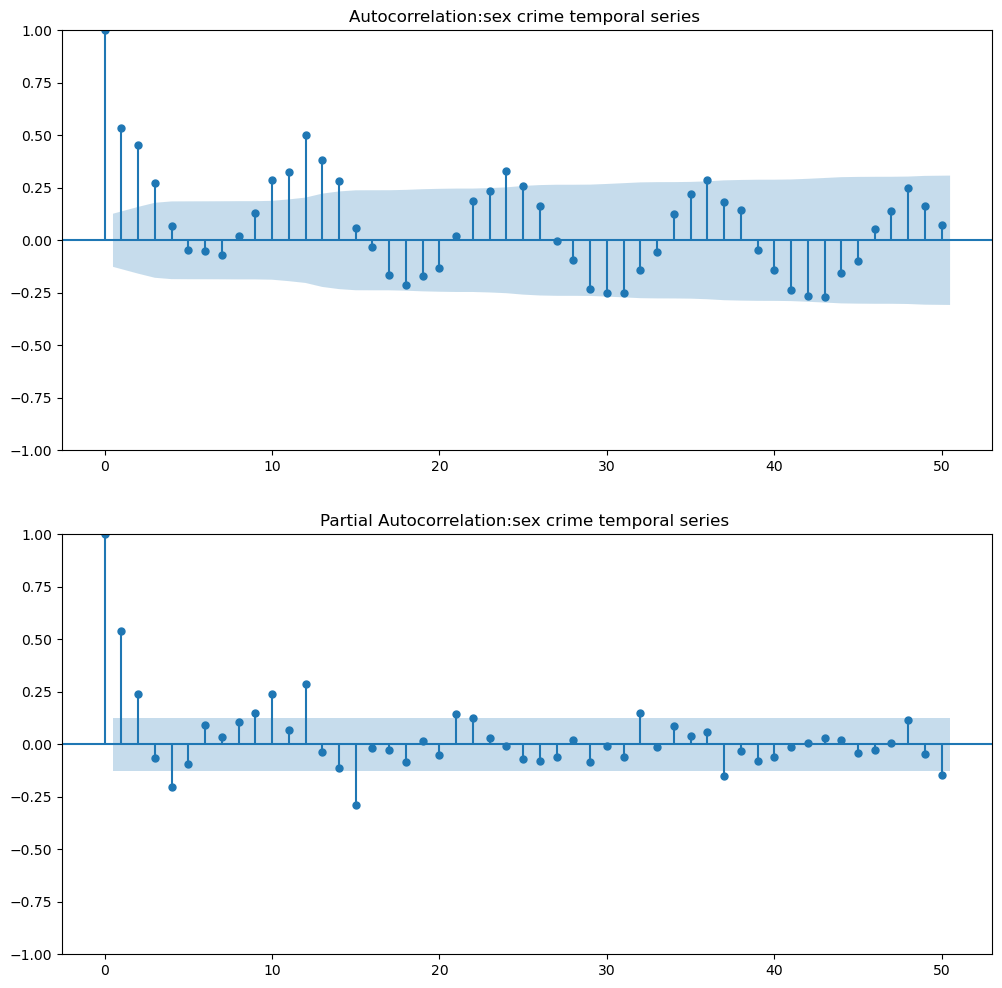

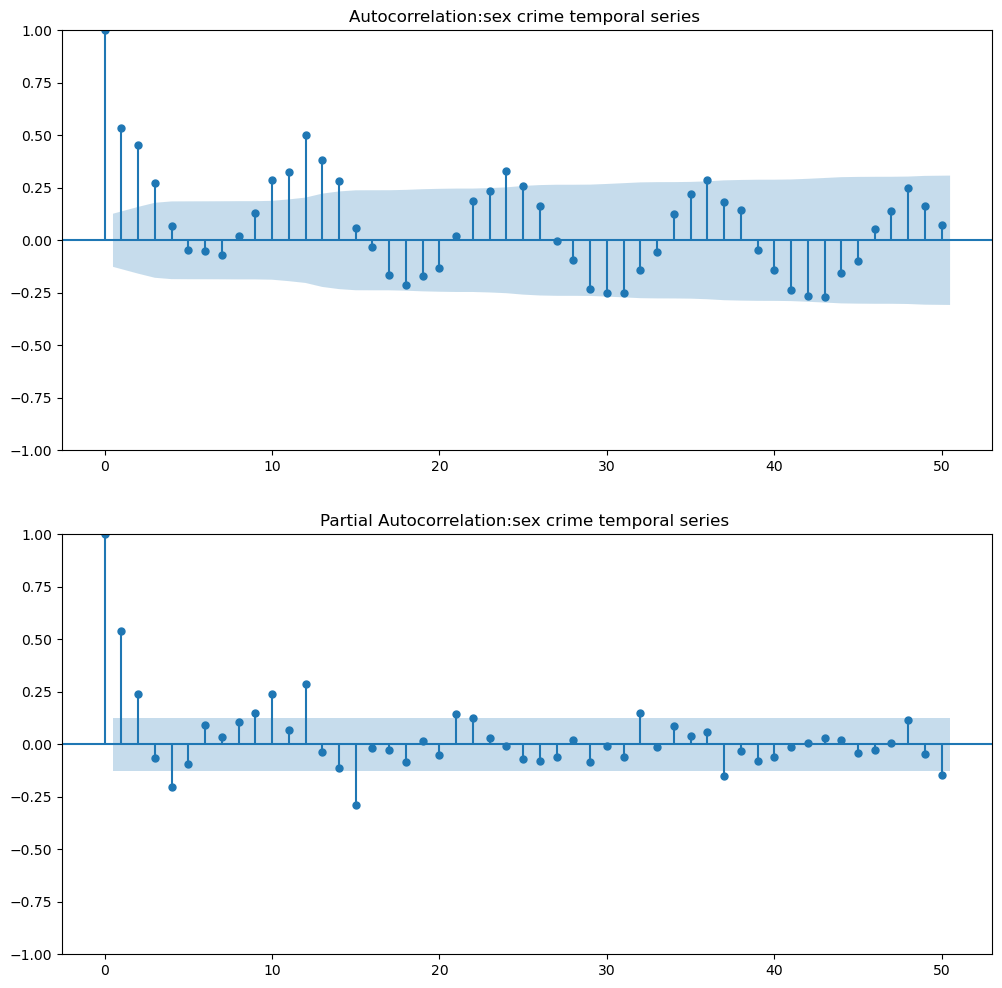

In [98]:
fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(12,12))

plot_acf(temp_sex.values,title='Autocorrelation:sex crime temporal series ',lags=50,ax=axs[0])
plot_pacf(temp_sex.values,title='Partial Autocorrelation:sex crime temporal series ',lags=50,ax=axs[1])

The ACF and PACF all indicate strong seasonality of temporal series.

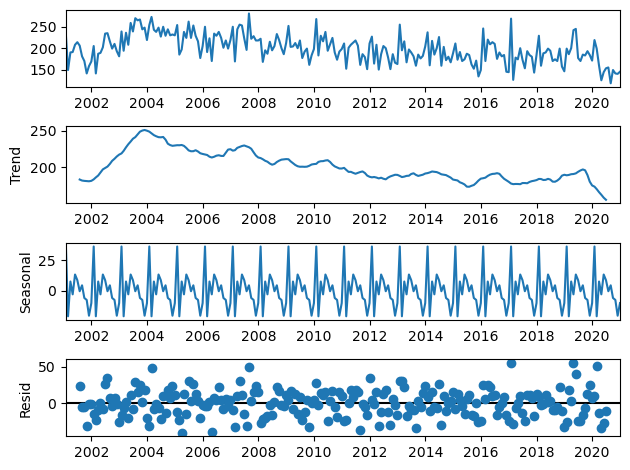

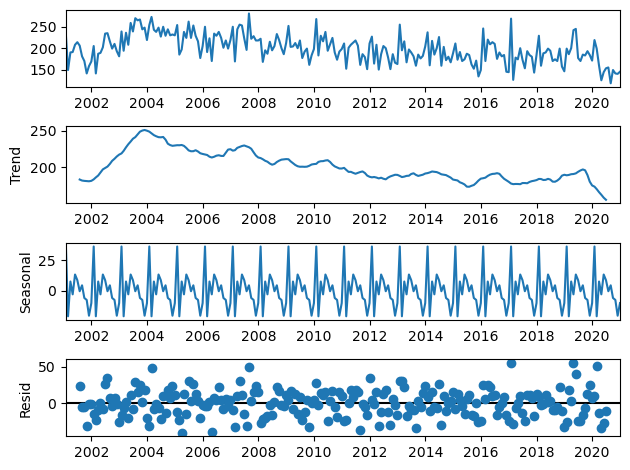

In [99]:
# check whether seasonal pattern exists
from statsmodels.tsa.seasonal import seasonal_decompose
child_temp_decomp=seasonal_decompose(temp_children)
child_temp_decomp.plot()

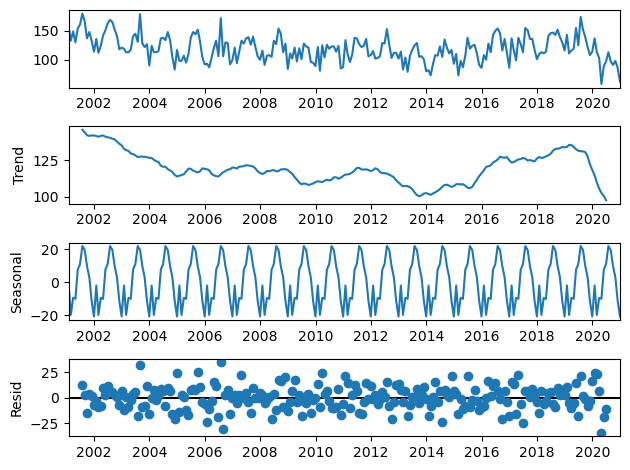

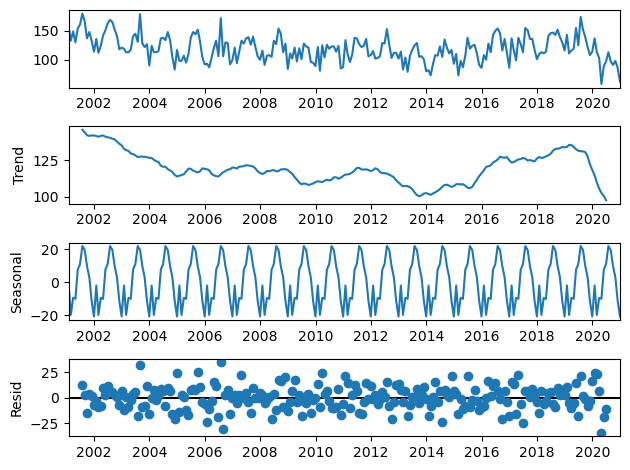

In [110]:
# check seasonality of sex crime
sex_temp_decomp=seasonal_decompose(temp_sex)
sex_temp_decomp.plot()

c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


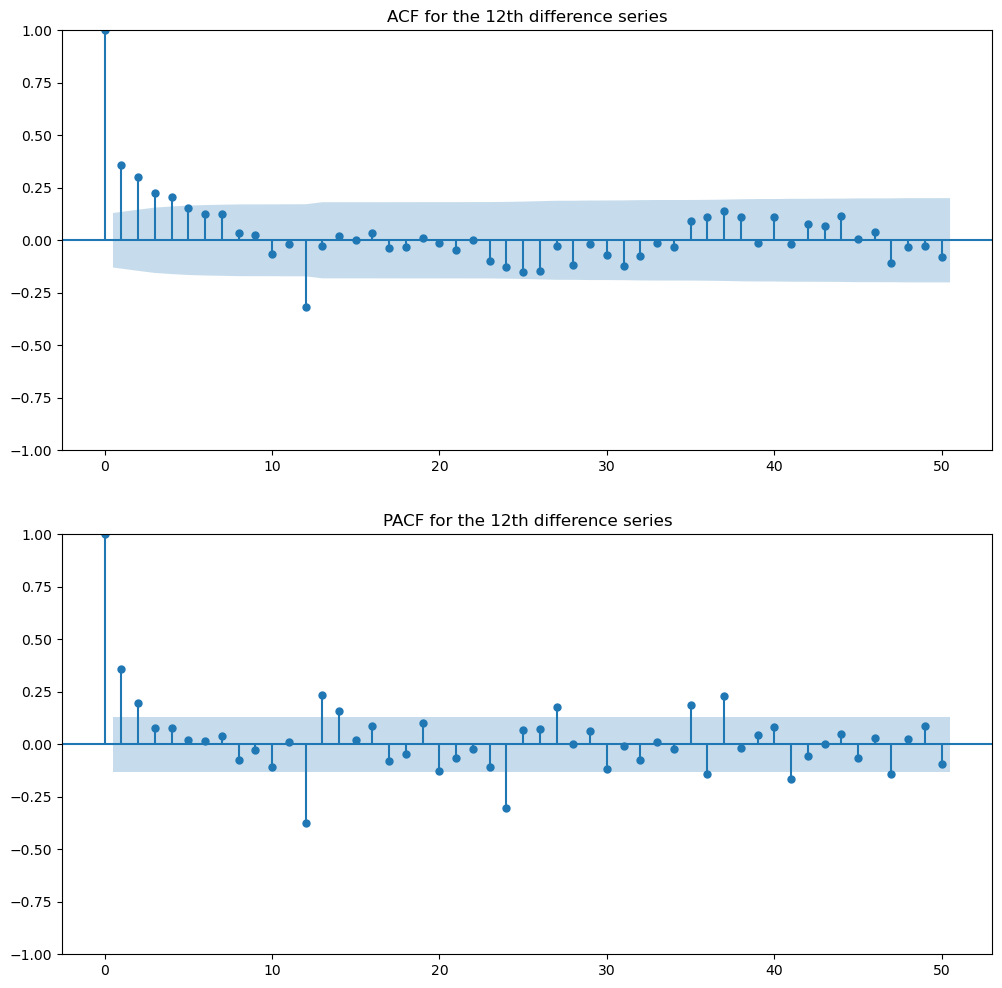

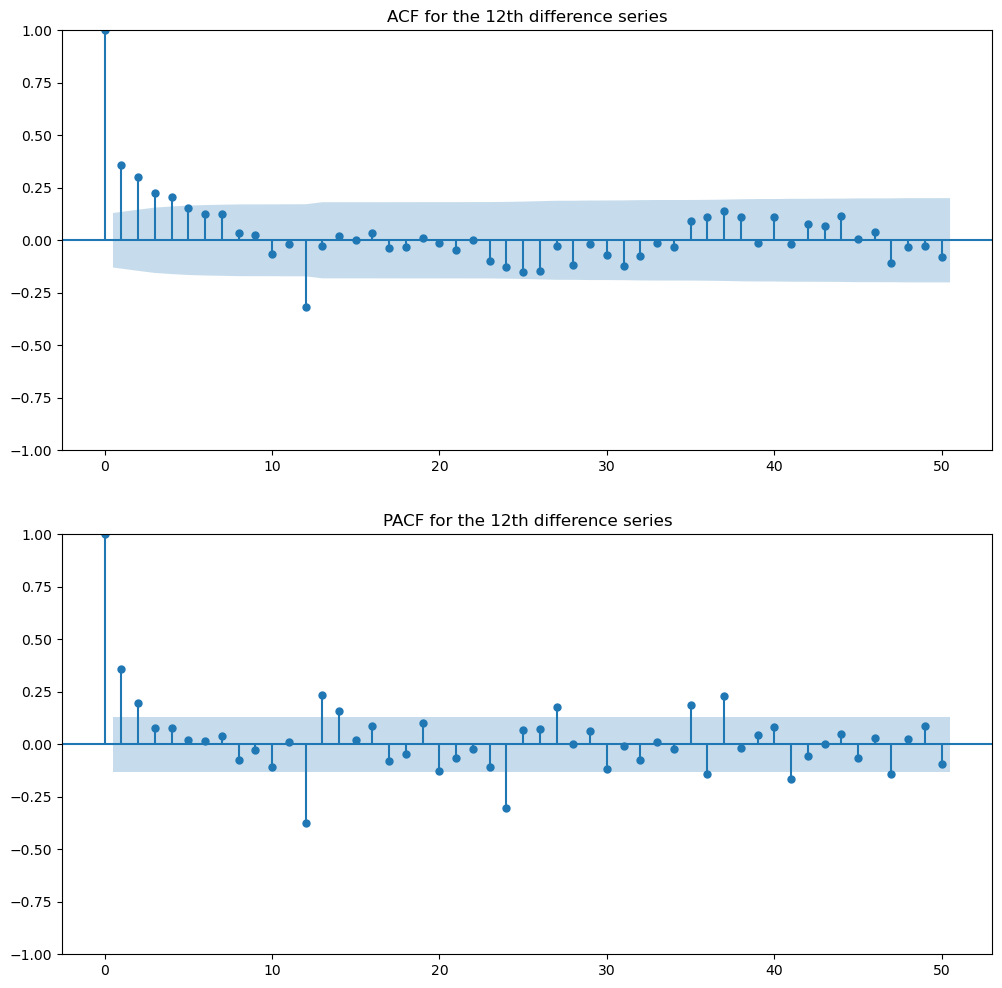

In [111]:
# Try to remove seasonality of crime involving children 
crime_temp_diff12=temp_children.diff(periods=12)[12:]

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
plot_acf(crime_temp_diff12,title='ACF for the 12th difference series',lags=50,ax=axs[0])
plot_pacf(crime_temp_diff12,title='PACF for the 12th difference series',lags=50,ax=axs[1])

c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


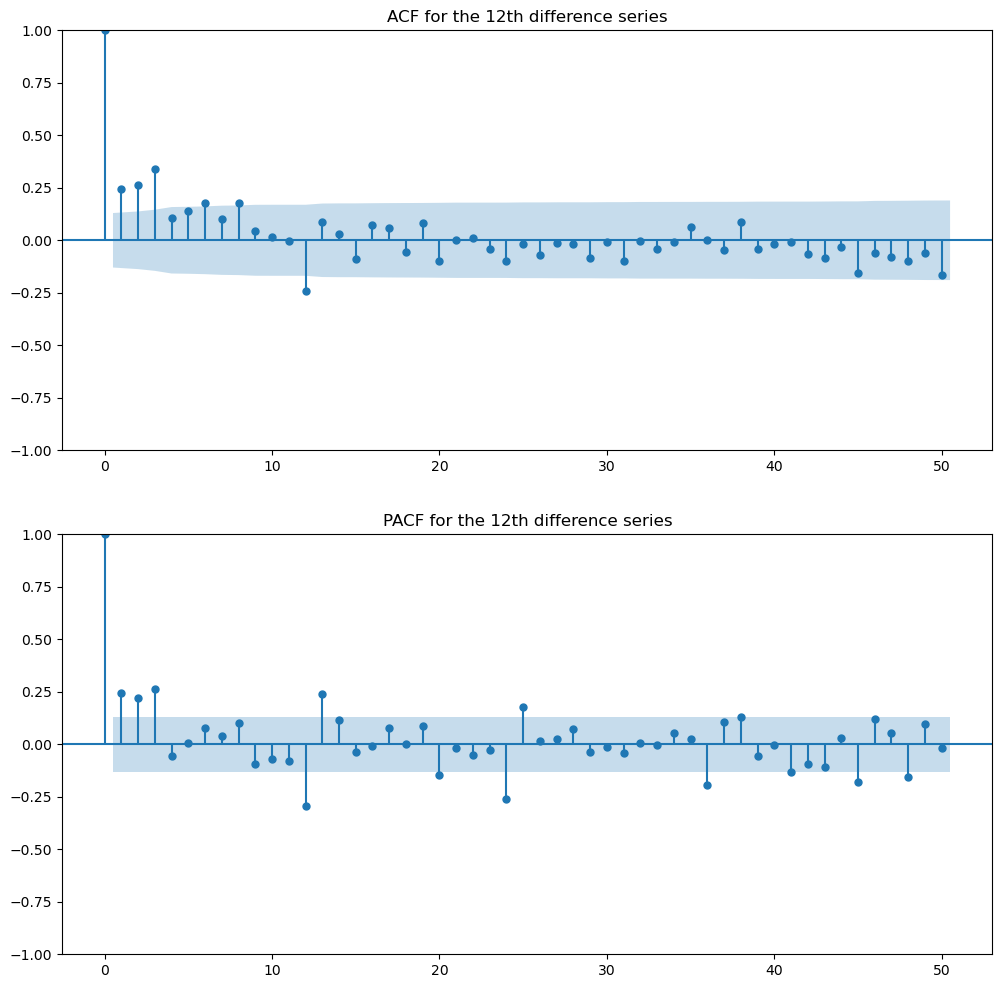

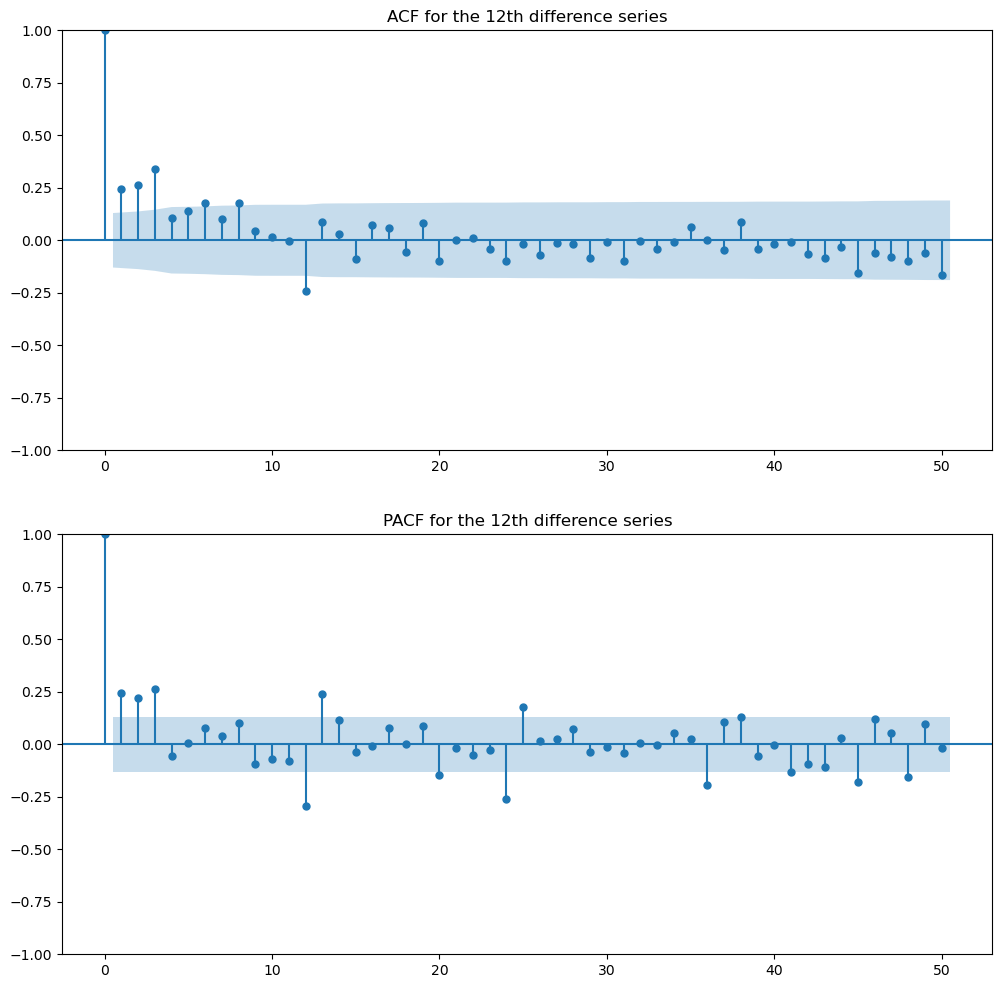

In [113]:
# Try to remove seasonality of sex crime 
crime_temp_diff12=temp_sex.diff(periods=12)[12:]

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
plot_acf(crime_temp_diff12,title='ACF for the 12th difference series',lags=50,ax=axs[0])
plot_pacf(crime_temp_diff12,title='PACF for the 12th difference series',lags=50,ax=axs[1])

## Steps of ARIMA
* model parameter
$ ARIMA (p,d,q)* (P,D,Q)S $

PACF-> AR->p,P

ACF-> MA -> q,Q

p = non-seasonal AR order,
d = non-seasonal differencing,
q = non-seasonal MA order,
P = seasonal AR order,
D = seasonal differencing,
Q = seasonal MA order,

S = time span of repeating seasonal pattern.

In [128]:
# get model
# the following code is adapted from https://pypi.org/project/pmdarima/
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
temp_children_train,temp_children_test=train_test_split(temp_children, train_size=0.8)


model_children = auto_arima(temp_children_train, start_p = 1, start_q = 1,
                          max_p = 4, max_q = 4, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # no need to know if an order does not work
                          suppress_warnings = True,  # no convergence warnings
                          stepwise = True)           # set to stepwise



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1635.831, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1741.291, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1690.440, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1675.842, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1739.330, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1715.520, Time=0.09 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1637.821, Time=0.46 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1637.820, Time=0.70 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1674.469, Time=0.27 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1637.823, Time=0.70 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1637.824, Time=0.70 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1705.660, Time=0.20 sec
 ARIMA(0,0,2)(0,1,1)[12] inte

In [114]:
# get model for the sex crime
temp_sex_train,temp_sex_test=train_test_split(temp_sex, train_size=0.8)


model_sex = auto_arima(temp_sex_train, start_p = 1, start_q = 1,
                          max_p = 4, max_q = 4, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # no need to know if an order does not work
                          suppress_warnings = True,  # no convergence warnings
                          stepwise = True)           # set to stepwise



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1639.978, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1558.115, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1577.927, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1539.733, Time=0.24 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.21 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1599.466, Time=0.15 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1508.964, Time=0.23 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1529.250, Time=0.10 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1509.113, Time=0.47 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1496.9

In [115]:
# To print the summary
model_sex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  192
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -742.964
Date:                             Sun, 19 Mar 2023   AIC                           1493.929
Time:                                     23:36:57   BIC                           1506.678
Sample:                                 01-31-2001   HQIC                          1499.099
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8590      0.038    -22.393      0.000      -0.934      -0.784
ar.S.L12      -0.4956      0.080     -6.182      0.000      -0.653      -0.338
ar.S.L24      -0.3579      0.075     -4.776      0.000      -0.505      -0.211
sigma2       227.4751     26.076      8.723      0.000     176.367     278.583
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.34   Prob(JB):                         0.91
Heteroskedasticity (H):               0.75   Skew:                             0.01
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

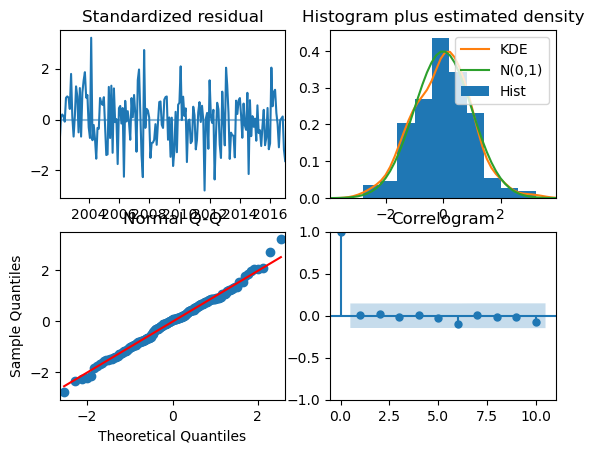

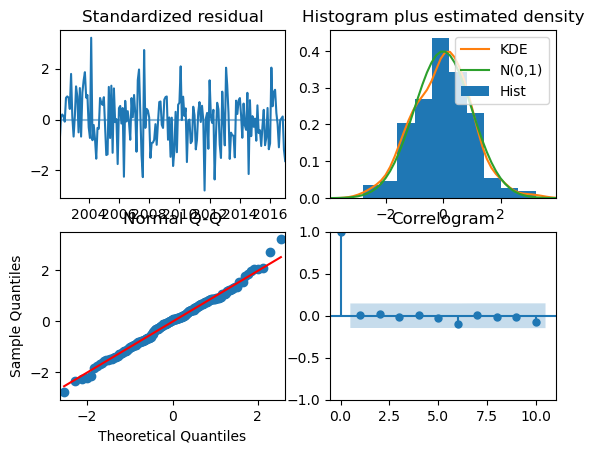

In [130]:
# Check the model by plotting diagnostic 
model_children.plot_diagnostics()

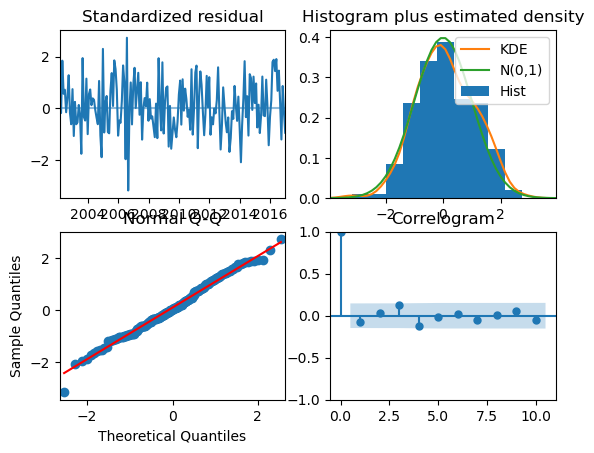

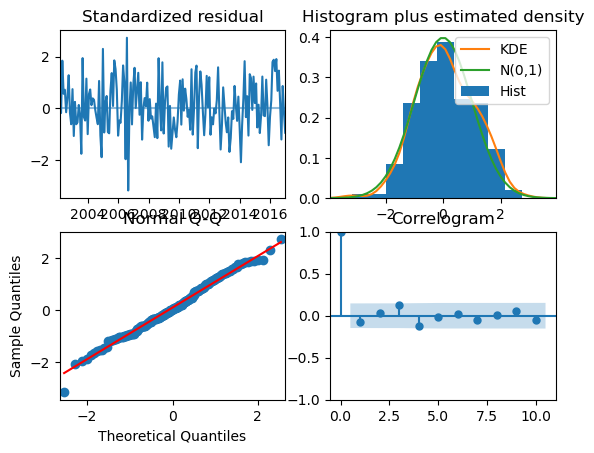

In [129]:
# Check the model by plotting diagnostic 
model_sex.plot_diagnostics()

In [133]:
# Use model to make forcast
pred_c=model_children.predict(temp_children_test.shape[0])
pred_s=model_sex.predict(temp_sex_test.shape[0])

In [134]:
# evaluate model
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
print(f'SARIMAX for Crime against Children RMSE:{rmse(temp_children_test, pred_c)}')
print(f'SARIMAX for Sex Crime RMSE:{rmse(temp_sex_test, pred_s)}')

# Calculate mean squared error
print(f'SARIMAX for Crime against Children MSE:{mean_squared_error(temp_children_test, pred_c)}')
print(f'SARIMAX for Crime against Children MSE:{mean_squared_error(temp_sex_test, pred_s)}')


SARIMAX for Crime against Children RMSE:28.420230745601046
SARIMAX for Sex Crime RMSE:33.00470358441279
SARIMAX for Crime against Children MSE:807.709515633207
SARIMAX for Crime against Children MSE:1089.3104586949505


Text(0.5, 1.0, 'SARIMAX Prediction of Crime Against Children')

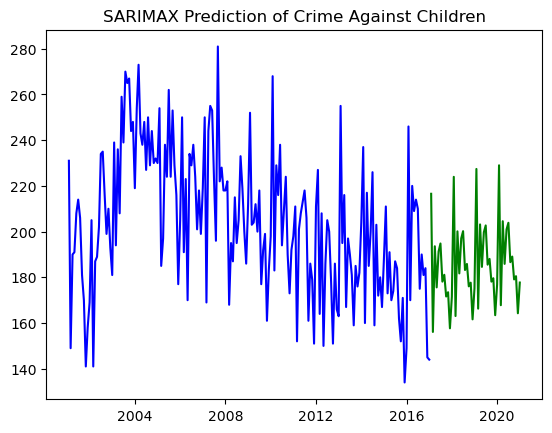

In [131]:
# Visualise the forcasts
x=temp_children.index


plt.plot(x[:temp_children_train.shape[0]], temp_children_train, c='blue')

#plt.plot(x[:temp_children_train.shape[0]], temp_children_test, c='blue')
plt.plot(x[temp_children_train.shape[0]:], pred_c, c='green')
plt.title("SARIMAX Prediction of Crime Against Children")



Text(0.5, 1.0, 'SARIMAX Prediction of Sex Crime')

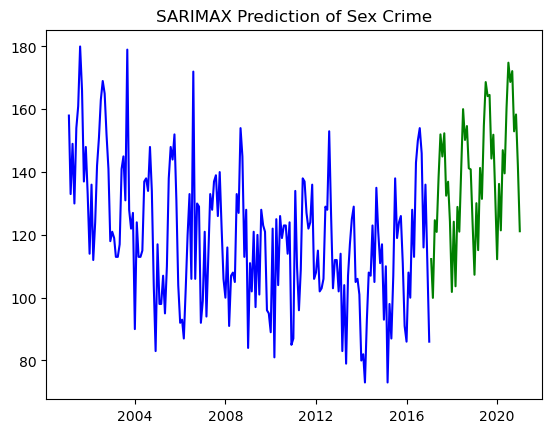

In [136]:
# Visualise the forcasts
x=temp_sex.index


plt.plot(x[:temp_sex_train.shape[0]], temp_sex_train, c='blue')

#plt.plot(x[:temp_children_train.shape[0]], temp_children_test, c='blue')
plt.plot(x[temp_sex_train.shape[0]:], pred_s, c='green')
plt.title("SARIMAX Prediction of Sex Crime")



# Clustering
## DBSCAN


In [137]:
# get the coordinates of crime point
coords_c=np.array(crime_children[['Longitude','Latitude']],dtype='float64')
coords_w=np.array(crime_sexual[['Longitude','Latitude']],dtype='float64')


In [139]:
# define the number of kilometers in one radian
# the algorithm ball_tree requires radian data
kms_per_radian = 6371.0088
epsilon=0.1/kms_per_radian # the range of cluster is innitisally set intuitively


In [140]:
from sklearn.cluster import DBSCAN
model=DBSCAN(eps=epsilon,min_samples=50,algorithm='ball_tree',metric='haversine')
clusters=model.fit(np.radians(coords_c))
labels=clusters.labels_
num_clusters=len(set(labels))
print(f'Number of clusters (children): {len(set(labels))}')

Number of clusters (children): 37


In [141]:
from sklearn.cluster import DBSCAN
model=DBSCAN(eps=epsilon,min_samples=50,algorithm='ball_tree',metric='haversine')
clusters=model.fit(np.radians(coords_w))
labels=clusters.labels_
num_clusters=len(set(labels))
print(f'Number of clusters (sex crime): {len(set(labels))}')

Number of clusters (sex crime): 44
